## Dollar Price Model

This notebook presents a model that utilizes reference and trade history data to accurately predict dollar prices. Based on the foundation of the yield spread model, this adaptation incorporates an attention layer positioned between two LSTM layers. The model's training encompasses data spanning from January 1, 2023, to April 1, 2023, while the test set is limited to the month of April 2023.


Last Update: Converting predicted dollar price to yield

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import IDENTIFIERS, NON_CAT_FEATURES_DOLLAR_PRICE, BINARY_DOLLAR_PRICE, CATEGORICAL_FEATURES_DOLLAR_PRICE,PREDICTORS_DOLLAR_PRICE
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES
from ficc.utils.auxiliary_variables import COUPON_FREQUENCY_TYPE

Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-09-15 16:19:36.146333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 16:19:36.265489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 16:19:36.266338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery and storage client

In [4]:
bq_client = bigquery.Client()
storage_client = storage.Client()

Declaring hyper-parameters

In [5]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 2
NUM_FEATURES = 5

Checking if the treasury spreads and target attention features are present in PREDICTORS 

In [6]:
if 'target_attention_features' not in PREDICTORS_DOLLAR_PRICE:
    PREDICTORS_DOLLAR_PRICE.append('target_attention_features')

#### Data Preparation
Our data retrieval process involves accessing the data from a designated GCP bucket. To prepare the data, we utilize the ficc Python package, which offers comprehensive functionality and tools for data preparation. For more detailed information on the specific steps involved in data preparation, including data cleaning, feature engineering, and preprocessing, please refer to the accompanying [code](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb) that provides deeper insights into our data preparation pipeline. This comprehensive approach ensures that the data utilized in our analysis is carefully curated and optimized to yield accurate and reliable results.

In [7]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# with fs.open('automated_training/processed_data_dollar_price.pkl') as f:
with fs.open('ahmad_data/processed_data_dollar_price_2023-09-12-21:27.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 21.7 s, sys: 6.51 s, total: 28.2 s
Wall time: 1min 15s


#### Date range for data

In [8]:
data.trade_date.max()

Timestamp('2023-07-31 00:00:00')

In [9]:
data.trade_date.min()

Timestamp('2023-05-01 00:00:00')

In [10]:
data['trade_history'] = data['trade_history_dollar_price'][:]

In [11]:
print(f'Restricting history to {SEQUENCE_LENGTH} trades')
data.trade_history = data.trade_history.apply(lambda x: x[:SEQUENCE_LENGTH])
data.target_attention_features = data.target_attention_features.apply(lambda x:x[:SEQUENCE_LENGTH])

Restricting history to 2 trades


In [12]:
data.trade_history.iloc[0].shape

(2, 5)

In [13]:
data.target_attention_features.iloc[0].shape

(1, 3)

In [14]:
len(data)

2378998

In [15]:
data = data.sort_values(by='trade_datetime', ascending=True)

### Creating features from trade history


This implementation builds upon Charles's original approach. Rather than relying on the yield spread, we have opted to utilize the dollar price of previous trades. This adjustment acknowledges the importance of the historical dollar prices in our analysis and allows us to capture valuable insights for more accurate predictions. By leveraging this alternative approach, our primary objective is to not only refine the model's performance but also extend its capacity to provide more robust estimations for a larger number of CUSIPs.

In [16]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

dp_variants = ["max_dp", "min_dp", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
dp_feats = ["_dp", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in dp_variants:
        for suffix in dp_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    dollar_price = trade[0]
    ttypes = ttype_dict[(trade[2],trade[3])] + row.trade_type
    seconds_ago = trade[4]
    quantity_diff = np.log10(1 + np.abs(10**trade[1] - 10**row.quantity))
    return [dollar_price, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_dp_t = trade; max_dp = trade[0]
    min_dp_t = trade; min_dp = trade[0]
    max_qty_t = trade; max_qty = trade[1]
    min_ago_t = trade; min_ago = trade[4]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[4] <= 0: 
            continue
 
        if trade[0] > max_dp: 
            max_dp_t = trade
            max_dp = trade[0]
        elif trade[0] < min_dp: 
            min_dp_t = trade; 
            min_dp = trade[0]

        if trade[1] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[1]
        if trade[4] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[4]
            
        side = ttype_dict[(trade[2],trade[3])]
        if side == "D":
            if trade[4] < D_min_ago: 
                D_min_ago_t = trade
                D_min_ago = trade[4]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[4] < P_min_ago: 
                P_min_ago_t = trade
                P_min_ago = trade[4]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[4] < S_min_ago: 
                S_min_ago_t = trade
                S_min_ago = trade[4]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_dp":max_dp_t,
                          "min_dp":min_dp_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in dp_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [17]:
%%time
temp = data[['cusip',
             'trade_history',
             'quantity',
             'trade_type']].parallel_apply(trade_history_derived_features, axis=1)

CPU times: user 37.6 s, sys: 6.14 s, total: 43.7 s
Wall time: 1min 25s


In [18]:
YS_COLS = get_trade_history_columns()

In [19]:
data[YS_COLS] = pd.DataFrame(temp.tolist(), index=data.index)

In [20]:
data = data.sort_values('trade_datetime',ascending=False)

The purpose of this feature is to conduct a thorough check for any NaN values within the trade history. It's important to note that while this feature serves as a quality control measure, it does not contribute to the training of the model itself. **Its sole purpose is to ensure the integrity and reliability of the data used in the model training process, guaranteeing that any missing values or inconsistencies are identified and appropriately addressed prior to model training.**

In [21]:
%%time
print(len(data))
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
data = data.dropna(subset=['trade_history_sum'])
print(len(data))

2378998
2378998
CPU times: user 13.4 s, sys: 3.15 s, total: 16.5 s
Wall time: 18.1 s


In [22]:
#For the purpose of plotting, not used in training
data.purpose_sub_class.fillna(0, inplace=True)

In [23]:
def duration(coupon, ytw, years, dollar_price, peryear=2):
    ytw = ytw.clip(0.001,np.inf)
    c = (coupon/100) / peryear
    y = (ytw/10000) / peryear
    n = years * peryear
    m = peryear
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y))
    modified_duration = macaulay_duration / (1 + y)
    dv01 = modified_duration * dollar_price / 10000
    return dv01

dv01 = duration(data.coupon, data.last_yield, data.last_duration, data.last_dollar_price)

In [24]:
def add_additional_feature(data):
    data['diff_ficc_ycl'] = data.new_ficc_ycl - data.last_ficc_ycl
    data['diff_ficc_treasury_spread'] = data.last_ficc_ycl - (data.treasury_rate * 100)
    data['dv01'] = dv01
    data['approx_dpd'] =  data.dv01 * data.diff_ficc_ycl
    data['overage'] =  (data.last_dollar_price + data.approx_dpd - data.next_call_price)
    data['de_minimis_gap'] = data.last_dollar_price - data.de_minimis_threshold
    return data

data = add_additional_feature(data)

In [25]:
# additional_features = ['diff_ficc_ycl','diff_ficc_treasury_spread','dv01','approx_dpd','overage','de_minimis_gap']
# for i in additional_features:
#     if i not in NON_CAT_FEATURES_DOLLAR_PRICE:
#         NON_CAT_FEATURES_DOLLAR_PRICE.append(i)
#         PREDICTORS_DOLLAR_PRICE.append(i)

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.


To address the issue of missing calc date and yield for certain CUSIPs, we have made the decision to remove the features that are constructed using the yield. This ensures that our data remains consistent and accurate, even for those CUSIPs where calc date and yield information is unavailable. By removing these features selectively, we can maintain the integrity of our data while still providing valuable insights for the majority of CUSIPs.

In order to enhance the model's accuracy in estimating prices for current trades, we propose incorporating the last dollar price as a feature during the training process. Based on our experience, we have observed that features derived from the last trade play a crucial role in accurate price estimation. By including the last dollar price as a feature, we can leverage this valuable information to improve the performance and predictive capabilities of the model.

In [26]:
auxiliary_features = ['dollar_price',
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'trade_history_sum',
                     'days_to_refund',
                     'last_rtrs_control_number',
                     'is_called',
                     'next_call_date',
                     'maturity_date',
                     'refund_date',
                     'yield',
                     'interest_payment_frequency',
                     'next_coupon_payment_date',
                     'previous_coupon_payment_date',
                     'is_callable',
                     'first_coupon_date',
                     'settlement_date',
                     'accrual_date',
                     'last_period_accrues_from_date',
                     'par_call_date',
                     'par_call_price',
                     'next_call_price',
                     'refund_price','trade_history_dollar_price']

In [27]:
processed_data = data[IDENTIFIERS + PREDICTORS_DOLLAR_PRICE + auxiliary_features]# + ['target_attention_features','yield_spread']]

Checking for missing data and NaN values

In [28]:
print(len(processed_data))
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)
processed_data.dropna(inplace=True , subset=PREDICTORS_DOLLAR_PRICE)
processed_data = processed_data[processed_data.callable_at_cav == False]
print(len(processed_data))

2378998
2286524


#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [29]:
categorical_feature_values = {'purpose_class' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                                                 47, 48, 49, 50, 51, 52, 53],
                              'rating' : ['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-',
                                         'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-' , 'D', 'NR', 'MR'],
                              'trade_type' : ['D', 'S', 'P'],
                              'incorporated_state_code' : ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU',
                                                         'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                                                         'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                                                         'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VI',
                                                         'VT', 'WA', 'WI', 'WV', 'WY'] }

In [30]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES_DOLLAR_PRICE:
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders_dollar_price.pkl','wb') as file:
    pickle.dump(encoders,file)

#### Splitting the data into train and test sets

In [31]:
train_dataframe = processed_data[(processed_data.trade_date < '07-01-2023')]
test_dataframe = processed_data[(processed_data.trade_date >= '07-01-2023')]
test_dataframe.interest_payment_frequency = test_dataframe.interest_payment_frequency.map(COUPON_FREQUENCY_TYPE)

In [32]:
len(train_dataframe)

1581763

In [33]:
len(test_dataframe)

704761

In [34]:
train_dataframe.trade_date.max()

Timestamp('2023-06-30 00:00:00')

In [35]:
test_dataframe.trade_date.min()

Timestamp('2023-07-03 00:00:00')

Converting data into format suitable for the model

In [36]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES_DOLLAR_PRICE + BINARY_DOLLAR_PRICE:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES_DOLLAR_PRICE:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [37]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.dollar_price

CPU times: user 8.87 s, sys: 305 ms, total: 9.18 s
Wall time: 9.18 s


In [38]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.dollar_price

CPU times: user 3.9 s, sys: 38.6 ms, total: 3.94 s
Wall time: 3.94 s


In [39]:
x_train[0].shape

(1581763, 2, 5)

In [40]:
x_test[2].shape

(704761, 47)

## LightGBM

In [41]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES_DOLLAR_PRICE ] = df[CATEGORICAL_FEATURES_DOLLAR_PRICE].astype('category')
    df[NON_CAT_FEATURES_DOLLAR_PRICE + BINARY_DOLLAR_PRICE] = df[NON_CAT_FEATURES_DOLLAR_PRICE + BINARY_DOLLAR_PRICE].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features'])
    return df

In [42]:
trainlabel = train_dataframe.dollar_price
testlabel = test_dataframe.dollar_price

In [43]:
%%time
gbt_td = gbmprep(train_dataframe[PREDICTORS_DOLLAR_PRICE])
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 14min 45s, sys: 2.07 s, total: 14min 47s
Wall time: 36.2 s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [44]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(test_dataframe[PREDICTORS_DOLLAR_PRICE]))
delta = testlabel - gbt_pred
print(delta.mean(), delta.abs().mean())

0.052768053635607444 0.529636942425121
CPU times: user 1min 18s, sys: 622 ms, total: 1min 18s
Wall time: 6.13 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

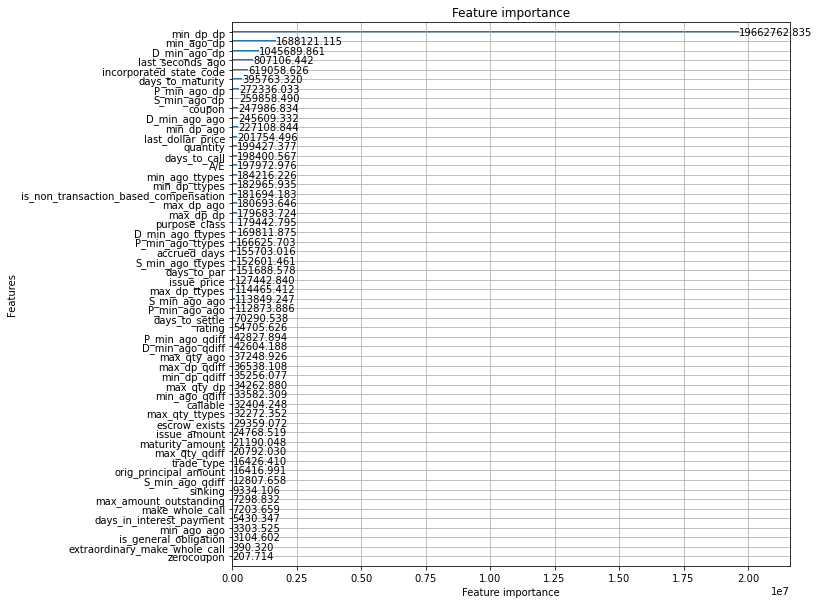

In [45]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [46]:
x_train[0] = x_train[0].astype(np.float32)

In [47]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

2023-09-15 16:24:08.541152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 16:24:08.544681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 16:24:08.545586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 16:24:08.546267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

#### Setting the seed for intialization of the layers

In [48]:
tf.keras.utils.set_random_seed(10)

#### Implementation of the model

We define an attention mechanism to weigh the importance of the target trade with respect to the output of the second LSTM layer. The attention mechanism first calculates the dot product between the LSTM output and the target trade using the Dot layer. The axes=\[2, 2\] means that we want to perform a dot product between the last axis of lstm ouput and the last axis of target trade sequence. The result is passed through a softmax activation function using the Activation layer to obtain the attention weights. The attention weights indicate the relative importance of each lstm hidden state with the target trade. Finally, the attention weights are used to calculate a context vector as a weighted sum of the traget trade using another Dot layer.

In [49]:
def generate_dollar_price_model():
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 


    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES_DOLLAR_PRICE + BINARY_DOLLAR_PRICE),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(SEQUENCE_LENGTH,50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)


    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)

    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES_DOLLAR_PRICE:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                       output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                       input_length= 1,
                                                                       name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    return model

In [50]:
model = generate_dollar_price_model()

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

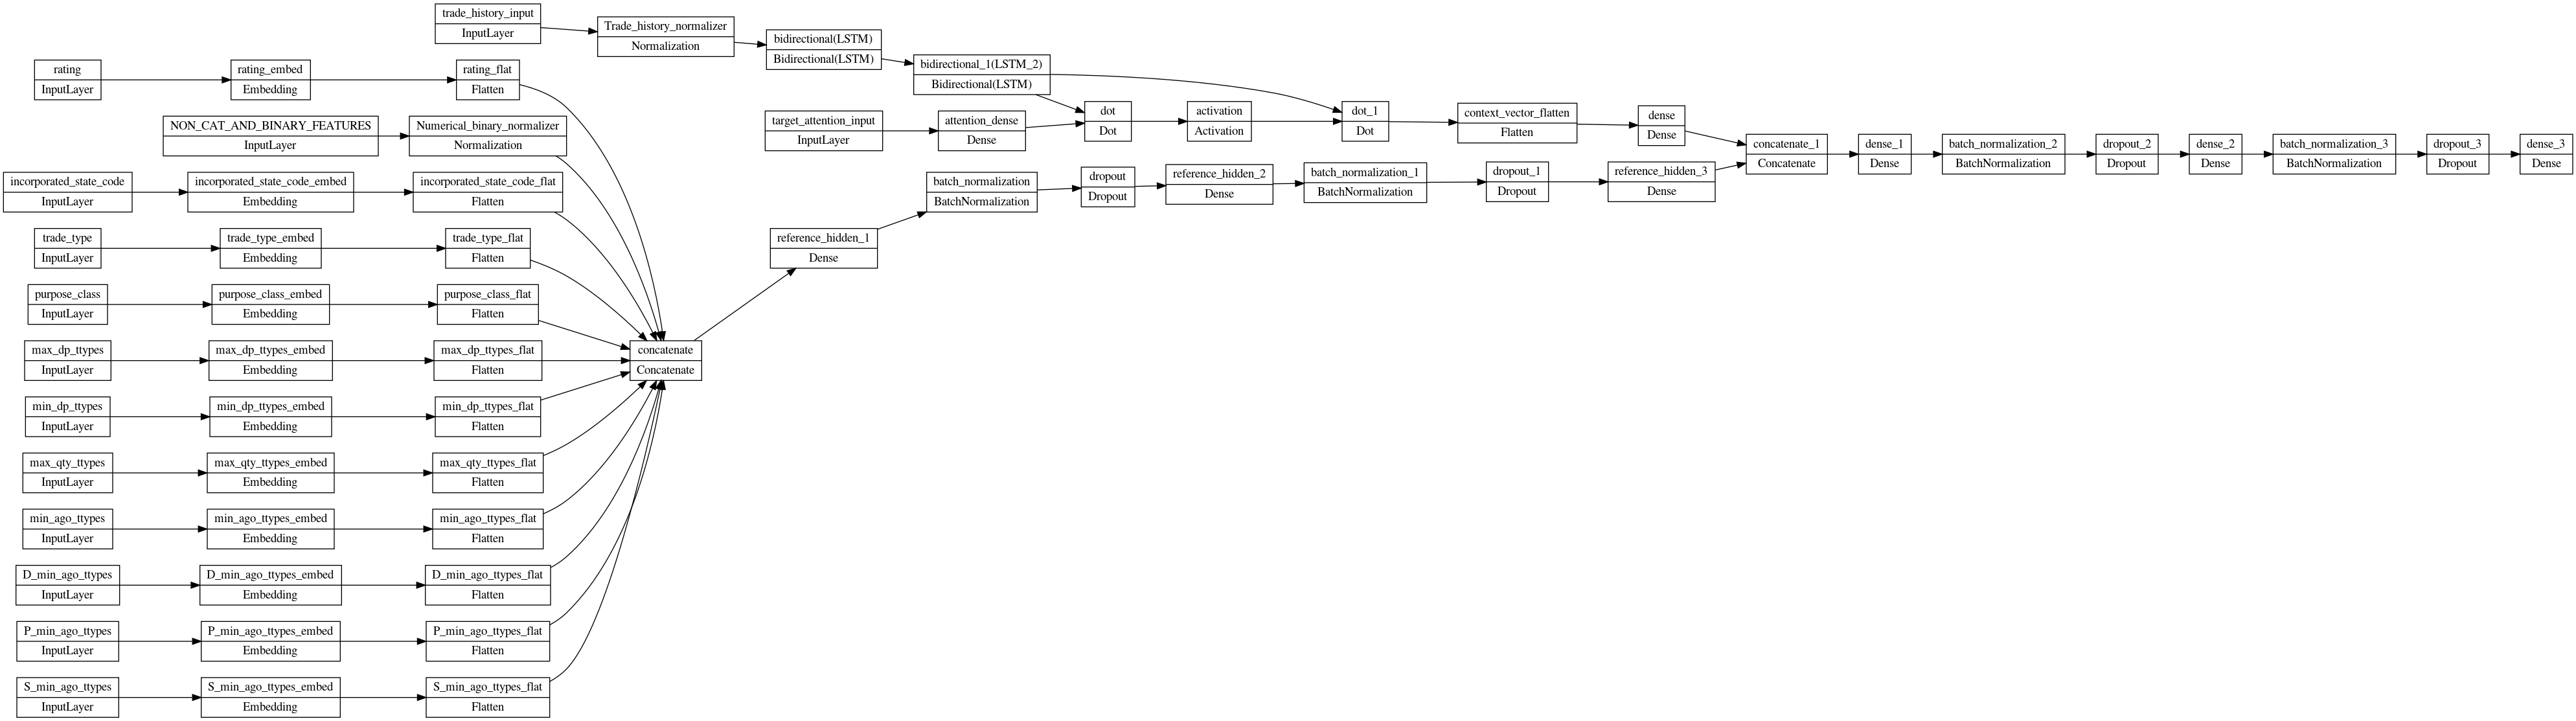

In [52]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [53]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [54]:
fit_callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=20,
                                               verbose=0,
                                               mode="auto",
                                               restore_best_weights=True,),
                 time_callback]

In [55]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.MeanAbsoluteError())

In [56]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100


2023-09-15 16:24:23.517935: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-15 16:24:28.270728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


1424/1424 [==============================] - ETA: 0s - loss: 99.1367

2023-09-15 16:24:50.587058: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1424/1424 [==============================] - 34s 16ms/step - loss: 99.1367 - val_loss: 96.0402
Epoch 2/100
1424/1424 [==============================] - 21s 14ms/step - loss: 89.1500 - val_loss: 82.3473
Epoch 3/100
1424/1424 [==============================] - 21s 14ms/step - loss: 72.7743 - val_loss: 63.4205
Epoch 4/100
1424/1424 [==============================] - 21s 15ms/step - loss: 51.2223 - val_loss: 39.0149
Epoch 5/100
1424/1424 [==============================] - 20s 14ms/step - loss: 24.9707 - val_loss: 10.5844
Epoch 6/100
1424/1424 [==============================] - 20s 14ms/step - loss: 2.8224 - val_loss: 0.8173
Epoch 7/100
1424/1424 [==============================] - 20s 14ms/step - loss: 1.4097 - val_loss: 0.7905
Epoch 8/100
1424/1424 [==============================] - 20s 14ms/step - loss: 1.3687 - val_loss: 0.7586
Epoch 9/100
1424/1424 [==============================] - 20s 14ms/step - loss: 1.3462 - val_loss: 0.8455
Epoch 10/100
1424/1424 [==============================] -

#### Plotting train vs validation loss

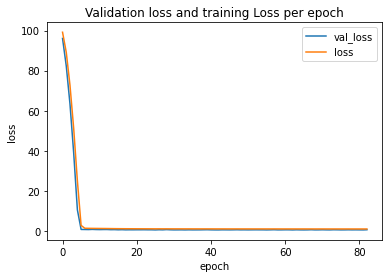

In [57]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [58]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders_dollar_price_illiquid.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ahmad_data', f"encoders_dollar_price_illiquid.pkl")

print("Saving and uploading model")
model.save(f"saved_model_test_class_model_{file_timestamp}")
# import shutil
# shutil.make_archive(f"model_dollar_price_june_16", 'zip', f"saved_model_dollar_price_{file_timestamp}")
# upload_data(storage_client, 'ahmad_data', f"model_dollar_price_june_16.zip")

file time stamp : 2023-09-15-16-54
Saving encoders and uploading encoders
File encoders_dollar_price_illiquid.pkl uploaded to ahmad_data.
Saving and uploading model


2023-09-15 16:54:21.166107: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model_test_class_model_2023-09-15-16-54/assets


INFO:tensorflow:Assets written to: saved_model_test_class_model_2023-09-15-16-54/assets


#### Gigaflops for one epoch of training

In [59]:
avg_time = np.mean(time_callback.times)

In [60]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9
print(gflops)

244.35712281623825


In [61]:
import numpy as np

### Test accuracy on the entire test set

##### New feautres : 0.468, 0.476, ,0.48, 0.488
##### Old features: 0.508, 0.495, 0.51, 0.514, 0.524

In [62]:
test_dataframe['predicted_dollar_price'] = model.predict(x_test, batch_size=BATCH_SIZE)
test_dataframe['absolute_delta'] = np.abs(test_dataframe.dollar_price - test_dataframe.predicted_dollar_price)

2023-09-15 16:54:36.487715: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [63]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.dollar_price - test_dataframe.predicted_dollar_price)), 3)}")

Test loss: 0.507


#### Accuracy on a daily basis for dealer dealer trades

In [64]:
for d in [d for d in pd.date_range(start="07/01/2023",end="07/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.dollar_price - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2023-07-03 MAE:0.42794289942489816
Date :2023-07-05 MAE:0.44724895508565876
Date :2023-07-06 MAE:0.46995171291790494
Date :2023-07-07 MAE:0.4733897603120558
Date :2023-07-10 MAE:0.49541614323947814
Date :2023-07-11 MAE:0.49019347739656366
Date :2023-07-12 MAE:0.48498661385738095
Date :2023-07-13 MAE:0.5026024751271096


2023-09-15 16:54:44.640604: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Date :2023-07-14 MAE:0.5153238269000884
Date :2023-07-17 MAE:0.5161894657453261
Date :2023-07-18 MAE:0.5661850962766649
Date :2023-07-19 MAE:0.5628789326996227
Date :2023-07-20 MAE:0.5582464876977397
Date :2023-07-21 MAE:0.5609100229591263
Date :2023-07-24 MAE:0.5299289245404544
Date :2023-07-25 MAE:0.5187102979182838
Date :2023-07-26 MAE:0.5141323709687923
Date :2023-07-27 MAE:0.5091616120634135
Date :2023-07-28 MAE:0.47538004190858935
Date :2023-07-31 MAE:0.49352700567415136


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [65]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
print(len(true_mid))
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.dollar_price

9478


In [66]:
%%time
mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")

10/10 [==============================] - 0s 5ms/step - loss: 0.4365
Test MAE: 0.437
CPU times: user 195 ms, sys: 15.9 ms, total: 211 ms
Wall time: 149 ms


### Plotting dollar price vs predicted dollar price

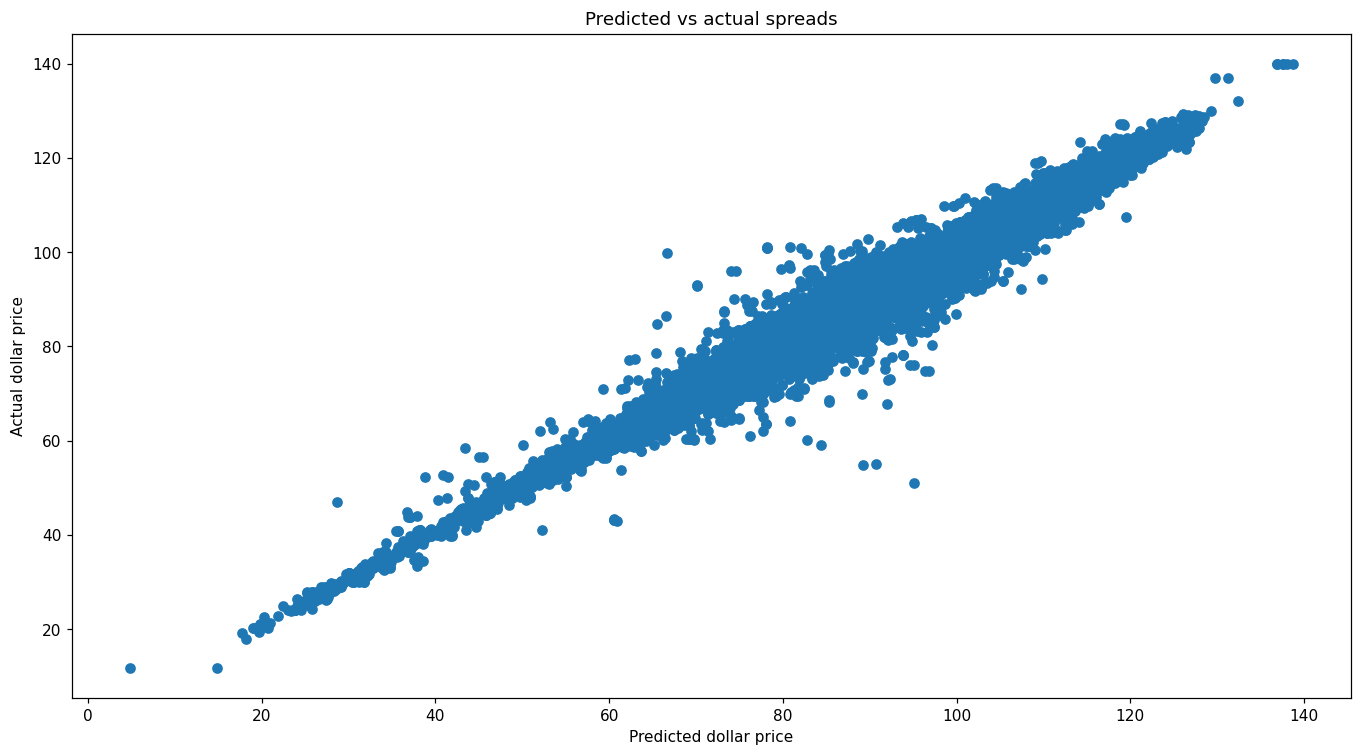

In [67]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted dollar price')
plt.ylabel('Actual dollar price')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_dollar_price, test_dataframe.dollar_price)

In [68]:
test_dataframe

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,settlement_date,accrual_date,last_period_accrues_from_date,par_call_date,par_call_price,next_call_price,refund_price,trade_history_dollar_price,predicted_dollar_price,absolute_delta
0,2023073111239400,925700BM7,True,True,False,False,True,False,False,False,...,2023-08-02,2014-09-23,2025-04-01,2023-10-01,100.0,100.0,NaN,"[[98.483, 4.397940158843994, 0.0, 0.0, 4.23565...",99.373993,0.109007
1,2023073111239300,41422PDP0,True,False,False,False,False,False,False,False,...,2023-08-02,2015-02-01,2025-06-01,2023-08-31,100.0,100.0,NaN,"[[96.587, 4.0, 0.0, 0.0, 4.388562971398075], [...",97.945114,0.358114
2,2023073111235700,988661HY3,True,False,False,False,True,False,False,False,...,2023-08-02,2015-03-12,2033-01-01,2025-07-01,100.0,100.0,NaN,"[[98.059, 4.397940158843994, 0.0, 0.0, 5.98901...",99.642746,0.630254
3,2023073111235600,988661HY3,True,False,False,False,True,False,False,False,...,2023-08-02,2015-03-12,2033-01-01,2025-07-01,100.0,100.0,NaN,"[[98.059, 4.397940158843994, 0.0, 0.0, 5.98901...",100.237167,1.035833
4,2023073111118300,378294FD9,True,True,False,False,False,False,False,False,...,2023-08-02,2012-12-27,2038-01-01,2023-08-31,100.0,100.0,NaN,"[[99.75, 4.0, 0.0, 0.0, 4.1853154580036565], [...",99.842575,0.137425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793180,2023070300006900,391882EW3,False,False,False,False,False,False,False,False,...,2023-07-06,2018-05-24,2028-01-15,NaT,100.0,100.0,NaN,"[[108.019, 4.397940158843994, 0.0, 0.0, 5.3804...",108.349533,0.233467
793181,2023070300006700,391882EW3,False,False,False,False,False,False,False,False,...,2023-07-06,2018-05-24,2028-01-15,NaT,100.0,100.0,NaN,"[[108.019, 4.397940158843994, 0.0, 0.0, 5.3804...",108.568443,0.014557
793182,2023070300004100,187145NJ2,True,True,False,False,False,False,False,False,...,2023-07-06,2021-09-28,2051-02-15,2031-08-15,100.0,100.0,NaN,"[[61.25, 4.301030158996582, 1.0, 0.0, 5.496074...",63.044987,0.044987
793183,2023070300002800,64972E4J5,True,True,False,False,False,False,False,False,...,2023-07-06,2023-06-20,2058-05-01,2031-06-01,100.0,100.0,NaN,"[[103.5, 4.301030158996582, 0.0, 1.0, 5.695016...",103.260353,0.239647


In [70]:
%%time
processed_data['predicted_dollar_price'] = model.predict(create_input(processed_data), batch_size=BATCH_SIZE)

CPU times: user 31.7 s, sys: 4.33 s, total: 36 s
Wall time: 25.7 s


In [71]:
from ficc.pricing.yield_rate import compute_yield

In [74]:
def get_predicted_yield(row):
    try:
        ytw, calc_date = compute_yield(row, price = row.predicted_dollar_price)
    except:
        ytw, calc_date = None, None
    return ytw

In [75]:
processed_data['converted_yield_dollar_price'] = processed_data.parallel_apply(lambda x: get_predicted_yield(x), axis=1)

/opt/conda/lib/python3.7/site-packages/numpy/core/numeric.py:2297: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)
/opt/conda/lib/python3.7/site-packages/numpy/core/numeric.py:2298: RuntimeWarning: invalid value encountered in multiply
  y = y * ones_like(cond)


In [ ]:
processed_data.to_pickle('dollar_prediction.pkl')